In [1]:
# NOT FOR MANUSCRIPT
import sys

import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt

print ("sys.version=", sys.version)
print ("np.__version__=", np.__version__)

sys.version= 3.6.3 |Anaconda, Inc.| (default, Oct 13 2017, 12:02:49) 
[GCC 7.2.0]
np.__version__= 1.13.3


### Geophysical Tutorial – coordinated by Matt  Hall

# The conjugate gradient method

Karl Schleicher, k_schleicher@hotmail.com

The conjugate gradient method can be used to solve many large linear geophysical problems. For example, least squares parabolic and hyperbolic radon transform, travel time tomography, least squares migration, and full waveform inversion (e.g. Witte et al., 2018). This tutorial revisits the _Linear inversion_ tutorial (Hall, 2016) that estimated reflectivity by deconvolving a known wavelet from a seismic trace using least squares. This tutorial solves the same problem using the conjugate gradient method. This problem is easy to understand and the concepts apply to other applications. The conjugate gradient method is often used to solve large problems because the least squares algorithm is much more expensive — that is, even a large computer may not be able to find a useful solution in a reasonable amount of time.  


## Introduction

The conjugate gradient method was originally proposed by Hestenes (1952) and extended to handle rectangular matrices by Paige & Saunders (1982). Claerbout (2012) demonstrated its application to geophysical problems. It is an iterative method. Each iteration applies the linear operator and its adjoint. The initial guess is often the zero vector and computation may stop after very few iterations.  

The adjoint of the operator $\mathbf{A}$, denoted as $\mathbf{A}^\mathrm{H}$, is defined as the operator that satisfies $\langle \mathbf{A} \mathbf{x}, \mathbf{y} \rangle$  = $\langle \mathbf{x}, \mathbf{A}^\mathrm{H} \mathbf{y} \rangle$ for all vectors $\mathbf{x}$ and $\mathbf{y}$ (where  $\langle \mathbf{u},\mathbf{v} \rangle$ represents the inner product between vectors $\mathbf{u}$ and $\mathbf{v}$). For a given matrix, the adjoint is simply the complex conjugate of the transpose of the matrix; this is also sometimes known as the Hermitian transpose, and sometimes written as $\mathbf{A}^\ast$ or $\mathbf{A}^\dagger$. Just to muddy the notation water even further, the complex conjugate transpose is denoted by `A.H` in NumPy and `A'` in MATLAB or Octave. However, we will implement the adjoint operator without forming any matrices.

In [2]:
# NOT FOR MANUSCRIPT
A  = np.matrix([[2,3], [(6+3j),-7]])

print("matrix")
print(A)
print("\ntranspose")
print(A.T)
print("\ncomplex conjugate transpose, aka Hermitian transpose")
print(A.H)

matrix
[[ 2.+0.j  3.+0.j]
 [ 6.+3.j -7.+0.j]]

transpose
[[ 2.+0.j  6.+3.j]
 [ 3.+0.j -7.+0.j]]

complex conjugate transpose, aka Hermitian transpose
[[ 2.-0.j  6.-3.j]
 [ 3.-0.j -7.-0.j]]


Many linear operators can be programmed as functions that are more intuitive and efficient than matrix multiplication. The matrices for operators like migration and FWI would be huge, but we avoid this problem because once you have the program for the linear operator, you can write the adjoint operator without computing matrices. Implementing the conjugate gradient algorithm using functions to apply linear operators and their adjoints is practical and efficient. It is wonderful to see programs that implement linear algorithms without matrices and the programming technique is a key theme in Claerbout’s 2012 book.

This tutorial provides a quick start to the conjugate gradient method based on Guo’s pseudocode (2002). Those interested in more depth can read Claerbout (2012) and Shewchuk (1994). A Jupyter Notebook with Python code to reproduce the figures in this tutorial is at: https://github.com/seg/tutorials.

<hr>

# OMIT SET-UP FROM MANUSCRIPT

## SET-UP — Construct the model `m`

We start with the slightly odd-seeming number of samples 51. This is because when we calculate the impedance contrasts (reflectivities), we'll lose a sample. Since I'd like 50 samples in the final reflectivity model `m`, we have to start with 50 + 1 samples in the impedance model.


In [3]:
# NOT FOR MANUSCRIPT

# Impedance, imp     VP    RHO
imp = np.ones(51) * 2550 * 2650
imp[10:15] =        2700 * 2750
imp[15:27] =        2400 * 2450
imp[27:35] =        2800 * 3000

# Compute reflectivity.
m = (imp[1:] - imp[:-1]) / (imp[1:] + imp[:-1])

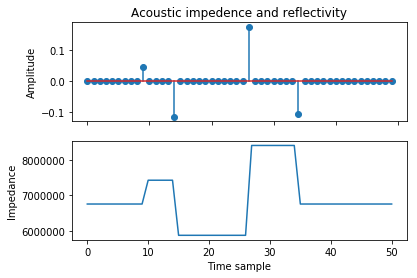

In [4]:
# NOT FOR MANUSCRIPT
fig, axs = plt.subplots(nrows=2)

ax = axs[0]
ax.set_title('Acoustic impedence and reflectivity')
ax.set_ylabel('Amplitude')
ax.set_xticklabels([])
ax.stem(m)

ax = axs[1]
ax.plot(imp)
ax.set_xlabel('Time sample')
ax.set_ylabel('Impedance')

plt.show()

We lost a sample, leaving 50. This is exactly we wanted.

## SET-UP — Make a wavelet

Now we make a Ricker wavelet to convolve on the reflectivity.

In [5]:
# NOT FOR MANUSCRIPT
from scipy.signal import ricker

# Use an odd number so we get a centered peak.
wavelet = ricker(points=21, a=2)

# Normalize the wavelet amplitude to 1 so that the amplitude
# relates directly to the reflectivity.
wavelet /= np.amax(wavelet)

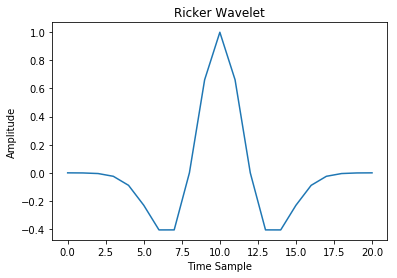

In [6]:
# NOT FOR MANUSCRIPT
fig, ax = plt.subplots()

ax.set_title('Ricker Wavelet')
ax.set_xlabel('Time Sample')
ax.set_ylabel('Amplitude')
ax.plot(wavelet)

plt.show()

# END OF SET-UP
<hr>

## The forward and adjoint operators

Starting with a known reflectivity model $\mathbf{m}$, we create synthetic seismic data  $\mathbf{d} = \mathbf{F} \mathbf{m}$, where $\mathbf{F}$ is the linear operator that performs the function "convolve with a Ricker wavelet". As in Hall (2016), who used $\mathbf{G}$ for the operator, this equation is used to create a synthetic seismic trace. Given such a trace and the operator, the conjugate gradient method can be used to estimate the original reflectivity.

The operator represents convolution with a wavelet. While Hall constructed $\mathbf{G}$ as a matrix by shifting the wavelet and padding with zeros, we implement our operator as a Python function. This is advantageous because it will allow us to solve the linear equation $\hat{\mathbf{m}} = \mathbf{F}^{-1}\mathbf{d}$ without ever having to construct (or invert) this matrix, which can become very large. Our matrix-free approach will be faster and use less memory than the matrix implementation. However, it only works in one dimension; the Python library SciPy has some tools for working in higher dimensions.

We can add one more feature to the operator and implement it with its adjoint. A convenient way to combine the two operations is to use a so-called 'object-oriented programming' approach and define a Python class. Then we can have two methods (i.e. functions) defined on the class: `forward`, implementing the forward operator, and `adjoint` for the adjoint operator, which in this case is correlation. 

In [7]:
class Operator(object):
    """A linear operator.
    """
    def __init__(self, wavelet):
        self.wavelet = wavelet

    def forward(self, v):
        """Defines the forward operator.
        """
        return np.convolve(v, self.wavelet, mode='same')
    
    def adjoint(self, v):
        """Defines the adjoint operator.
        """
        return np.correlate(v, self.wavelet, mode='same')

In [10]:
# NOT FOR MANUSCRIPT
# Dot product test.
w = np.array([1.0, -2.0, 0.5, 0, 0])
x = np.random.rand(50)
y = np.random.rand(50)

F = Operator(w)

convx = F.forward(x)
cadjy = F.adjoint(y)

print('<Fx, y>  =', np.dot(convx, y))
print('<x, F*y> =', np.dot(x, cadjy))
print('diff     =', np.dot(convx, y) - np.dot(x, cadjy))

<Fx, y>  = -6.71681713411
<x, F*y> = -6.71681713411
diff     = 0.0


Claerbout (2012) teaches how to write this kind of symmetrical code, and provides many examples of geophysical operators with adjoints (e.g. derivative vs negative derivative, causal integration vs anticausal integration, stretch vs squeeze, truncate vs zero pad). Writing functions to apply operators is more efficient then computing matrices.

Now that we have the operator, we can instantiate the class with a wavelet. This wavelet will be 'built in' to the instance `F`.

In [11]:
F = Operator(wavelet)

Now we can compute $\mathbf{d} = \mathbf{F}\,\mathbf{m}$ simply by passing the model `m` to the method `F.forward()`, which already has the wavelet:

In [12]:
d = F.forward(m)

This results in the synthetic seismogram shown in Figure 1.

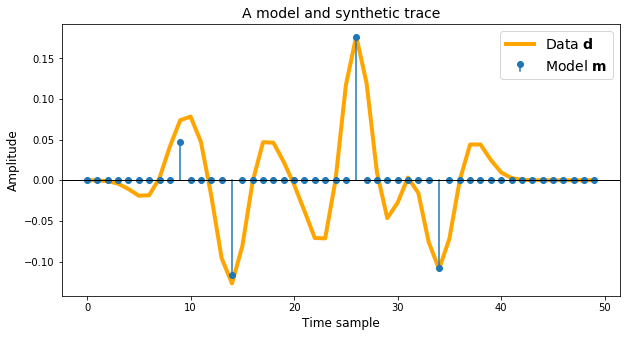

In [50]:
# NOT FOR MANUSCRIPT
fig, ax = plt.subplots(figsize=(10, 5))

plt.stem(m, label="Model $\mathbf{m}$", basefmt='none')
plt.axhline(c='k', lw=1)
ax.plot(d, 'orange', lw=4, zorder=1, label="Data $\mathbf{d}$")
ax.set_title('A model and synthetic trace', size=14)
ax.set_xlabel('Time sample', size=12)
ax.set_ylabel('Amplitude', size=12)
ax.legend(fontsize=14)

plt.savefig('figure1_model_data.png', dpi=300)
plt.show()

__Figure 1__: A plot of reflectivity model $\mathbf{m}$ (blue) and the synthetic seismic data $\mathbf{d}$ (orange).

<hr>

## The conjugate gradient method

Now that we have a synthetic, we wish to solve the linear inverse problem and estimate the model $\mathbf{m}$ from the data $\mathbf{d}$. The model can not be completely recovered because the Ricker wavelet is bandlimited, so some information is lost.

One way to solve linear problems is to start with an initial guess and iteratively improve the solution. The next few paragraphs derive an iterative method. You do not need to understand all the derivation, so you might want to lightly read it and move to the section about the pseudo code.

We start with an initial estimate for the model, $\hat{\mathbf{m}}_0 = \mathbf{0}$ (the zero vector) and compute the residual $\mathbf{r}_0 = \mathbf{d} - \mathbf{F}\, \hat{\mathbf{m}}_0$ (i.e. the difference between the data and the action of the forward operator on the model estimate). A good measure of the error in the initial solution is the inner product $\langle \mathbf{r}_0, \mathbf{r}_0 \rangle$ or `np.dot(r0, r0)` in code. This is equivalent to the squared norm (length) of the residual vector $\mathbf{r}_0$, and constitutes our cost function. If the cost is 0, or within some small tolerance, then we have a solution.

After a single iteration we have a low quality estimate. An improved solution is computed by selecting a direction $\mathbf{s}_0$ and a scale $\alpha_0$ to move $\hat{\mathbf{m}}_0$ to a new guess, $\hat{\mathbf{m}}_1 = \hat{\mathbf{m}}_0 + \alpha_0\,\mathbf{s}_0$. A good choice for $\mathbf{s}_0$ is the gradient $\mathbf{g}$ of $\langle \mathbf{r}_0, \mathbf{r}_0 \rangle$, which is given by the action of the adjoint operator on the residual: $\mathbf{F}^\mathrm{H} \mathbf{r}_0$. The gradient is the direction that will reduce the error the quickest. The scalar $\alpha_0$ is computed to minimize the residual, $\mathbf{r}_1 = \mathbf{d} - \mathbf{F}\,\hat{\mathbf{m}}_1 = \mathbf{d} - \mathbf{F} (\hat{\mathbf{m}}_0 + \alpha_0 \mathbf{s}_0) = \mathbf{r}_0  - \alpha_0 \mathbf{F}\,\mathbf{s}_0$. We can them compute $\alpha_0$ by taking the derivative of $\langle \mathbf{r}_1, \mathbf{r}_1\rangle$ with respect to $\alpha_0$, setting the derivative to 0, and solving for $\alpha_0$. The result is:

$$\alpha_0 = - \langle \mathbf{r}_0, \mathbf{F}\,\mathbf{s}_0\rangle\ /\ \langle \mathbf{F}\,\mathbf{s}_0, \mathbf{F}\,\mathbf{s}_0\rangle $$

These equations define a reasonable approach to iteratively improve an estimated solution and it is called “the steepest descent method”. The conjugate gradient algorithm builds on this. It is not much harder to implement, has similar cost per iteration, and faster convergence.

The first iteration of the conjugate gradient method is the same as the steepest descent method. The second (and later) iterations compute the gradient $\mathbf{g}_1$ and $\mathbf{F}\,\mathbf{g}_1$. With $\mathbf{s}_0$ and $\mathbf{F}\,\mathbf{s}_0$ from the previous iteration we can then compute the step direction. Scalars $\alpha$ and $\beta$ are computed to minimize

$$\mathbf{r}_2 = \mathbf{d} - \mathbf{F} (\hat{\mathbf{m}}_1 + \alpha\, \mathbf{s}_0 + \beta\, \mathbf{g}_1).$$

Some mathematical manipulations determine the best direction is $\mathbf{s}_1 = \mathbf{g}_1 + \beta\,\mathbf{s}_0$ where $\beta = \langle \mathbf{g}_1, \mathbf{g}_1 \rangle\ /\ \langle \mathbf{g}_0, \mathbf{g}_0 \rangle$.  The conjugate gradient algorithm is guaranteed to converge when the number of iterations is equal to the dimension of $\hat{\mathbf{m}}$, but only a few iterations often give sufficient accuracy. For our implementation, we'll start with a simplifed version of the pseudo-code provided by Guo (2002):

$\mathbf{\hat{m}} = \mathbf{0}$<br>
$\mathbf{r} = \mathbf{d} - \mathbf{F}\,\mathbf{\hat{m}}$<br>
$\mathbf{s} = \mathbf{0}$<br>
$\beta = 0$<br>

$\mathrm{iterate}\ n\ \mathrm{times}:$<br>
$\qquad \mathbf{g} = \mathbf{F}^\mathrm{H} \mathbf{r}$<br>
$\qquad \mathrm{if}\ \mathrm{not}\ \mathrm{first}\ \mathrm{iteration}:$<br>
$\qquad \qquad \beta = \langle \mathbf{g}, \mathbf{g} \rangle \ /\ \gamma$<br>
$\qquad \gamma = \langle \mathbf{g}, \mathbf{g} \rangle$<br>
$\qquad \mathbf{s} = \mathbf{g} + \beta\, \mathbf{s}$<br>
$\qquad \Delta \mathbf{r} = \mathbf{F}\, \mathbf{s}$<br>
$\qquad \alpha = -\langle \mathbf{r}, \Delta \mathbf{r} \rangle\ /\ \langle \Delta \mathbf{r}, \Delta \mathbf{r} \rangle$<br>
$\qquad \mathbf{\hat{m}} = \mathbf{\hat{m}} - \alpha\, \mathbf{s}$<br>
$\qquad \mathbf{r} = \mathbf{r} + \alpha \Delta\mathbf{r}$<br>

In [54]:
m_est = np.zeros_like(d)
r = d - F.forward(m_est)
s = np.zeros_like(d)
beta = 0
n = 5
cache = [m_est]
for i in range(n):
    g = F.adjoint(r)
    if i != 0:
        beta = np.dot(g, g) / gamma
    gamma = np.dot(g, g)
    s = g + beta * s
    deltar = F.forward(s)
    alpha = -np.dot(r, deltar) / np.dot(deltar, deltar)
    m_est = m_est - alpha * s
    r = r + alpha * deltar
    cache.append(m_est)

## Results

The conjugate gradient pseudo-code in the previous section was implemented in Python and used to invert for the reflectivity. Figure 2 shows the five iterations of the conjugate gradient method. The conjugate gradient method converged in only four iterations; the results of the fourth and fifth iteration almost exactly overlay on the plot. Fast convergence is important for a practical algorithm.

Figure 3 compares the original model, the data, and the model estimated using conjugate gradient inversion. Conjugate gradient inversion does not completely recover the model because the Ricker wavelet is bandlimitted, but sidelobes are reduced (for example samples 17 through 23). Figure 4 compares the the conjugate gradient model convolved with the Ricker wavelet with the original data to show the original data is well estimated.  This demonstrates there is more than one reflectivity sequence that when convolved with the Ricker wavelet that will fit the data, in particular the original model and the model estimated by the conjugate gradient method. It may be interesting to explore preconditioning operators that promote a sparse solution.

The Jupyter notebook provided with this tutorial further explores finding least-squares solutions using the conjugate gradient method. The notebook demonstrates how preconditioning can be used to promote a sparse solution. It also provides examples using the sparse solvers provided in the Python functions `scipy.sparse.linalg.cg()` and `scipy.sparse.linalg.lsqr()`.

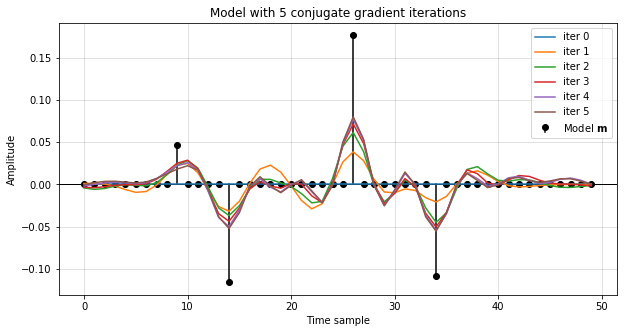

In [55]:
# NOT FOR MANUSCRIPT
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title(f'Model with {n} conjugate gradient iterations')
ax.set_xlabel('Time sample')
ax.set_ylabel('Amplitude')

plt.stem(m, label=r'Model $\mathbf{m}$', basefmt='none', linefmt='k', markerfmt='ko')
plt.axhline(color='k', lw=1)
for i, m_est in enumerate(cache):
    plt.plot(m_est, label=f'iter {i}')
plt.legend()
plt.grid(color='k', alpha=0.15)

plt.savefig('figure2_cg_est_iter.png', dpi=300)
plt.show()

**Figure 2** Model estimated by the first five iterations of conjugate gradient plotted with the original model.  Four iterations can be seen and the fifth nearly overlays the fourth.  Mathematically, convergence is ensured in 50 iterations (the dimension of the model), but it hardly changes after the fourth.

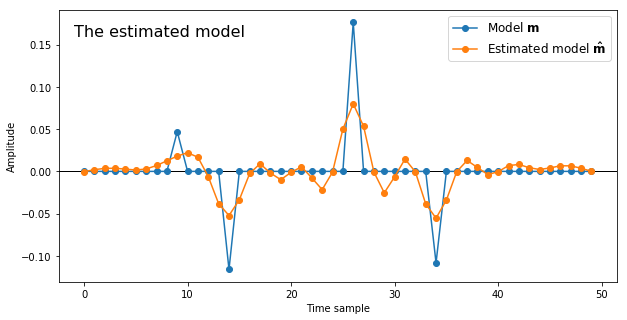

In [56]:
# NOT FOR MANUSCRIPT
fig, ax = plt.subplots(figsize=(10, 5))

#plt.stem(m, label=r'Model $m$', basefmt='none', linefmt='k', markerfmt='ko')
plt.axhline(color='k', lw=1)
# ax.plot(d, label=r'Data $d$')
#ax.plot(m_est, label=r'Estimated model $\hat{m}$')
ax.plot(m, 'o-', label=r'Model $\mathbf{m}$')
ax.plot(m_est, 'o-', label=r'Estimated model $\mathbf{\hat{m}}$')
ax.legend(fontsize=12)
ax.set_xlabel('Time sample')
ax.set_ylabel('Amplitude')
title = 'The estimated model'
ax.text(-1, 0.16, title, color='k', size=16)

plt.savefig('figure3_data_model_estmodel.png', dpi=300)
plt.show()

__Figure 3__: Comparison of the model, data (model convolved with a Ricker wavelet), and the model estimated using conjugate gradient inversion.  Conjugate gradient inversion does not completely recover the model because the Ricker wavelet is bandlimitted, but sidelobes are reduced (for example samples 17 through 23).

In [57]:
d_pred = F.forward(m_est)

In [58]:
# NOT FOR MANUSCRIPT

# Check the norm
difference = d - d_pred
misfit = np.linalg.norm(difference)**2
misfit

0.000731742625056066

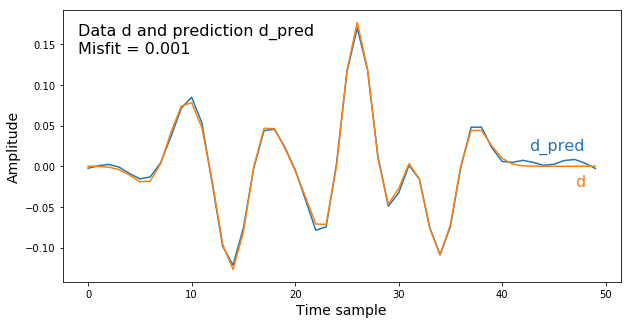

In [60]:
# NOT FOR MANUSCRIPT
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlabel('Time sample', size=14)
ax.set_ylabel('Amplitude', size=14)
ax.plot(d_pred, label="d_pred")
ax.plot(d, label='d')
title = 'Data d and prediction d_pred\nMisfit = {:.3f}'.format(misfit)
ax.text(-1, 0.14, title, color='k', size=16)
ax.text(48, 0.02, 'd_pred', ha='right', color='C0', size=16)
ax.text(48, -0.025, 'd', ha='right', color='C1', size=16)

plt.savefig('figure4_data_cg_pred.png', dpi=300)
plt.show()

__Figure 4__: Comparison of the predicted data `d_pred` from the conjugate gradient inversion with the original data `d`.  

## Conclusions

I described the conjugate gradient algorithm and presented an implementation. This is an iterative method that requires functions to apply the linear operator and its adjoint. Many linear operators that are familiar geophysical operations like convolution are more efficiently implemented without matrices. The reflectivity estimation problem described in Hall’s _Linear inversion_ tutorial was solved using the conjugate gradient method.  Convergence only took four iterations. The conjugate gradient method is often used to solve large problems because well known solvers like least squares are much more expensive.  

A Jupyter notebook to reproduce the figures in this article is at https://github.com/seg/tutorials.

## Acknowledgments
The SEG Seismic Working Workshop on Reproducible Tutorials held August 9 to 13 in Houston inspired this tutorial.  For more information visit: http://ahay.org/wiki/Houston_2017


## References
Claerbout, J., Fomel, S., 2012, Image Estimation by Example,
http://sepwww.stanford.edu/sep/prof/gee1-2012.pdf

Guo, J., Hongbo, Z., Young, J., Gray, S., 2002, Merits and challenges for accurate velocity model building by 3D gridded tomography, Geophysics. https://doi.org/10.1190/1.1817395 

Hall, M., 2016, Linear Inversion, The Leading Edge, pages 1085-1087. https://doi.org/10.1190/tle35121085.1

Hestenes, Magnus R.; Stiefel, Eduard, 1952, "Methods of Conjugate Gradients for Solving Linear Systems". Journal of Research of the National Bureau of Standards. 49 (6). doi:10.6028/jres.049.044

Paige, C. C., Saunders, M. A., 1982, LSQR: An Algorithm for Sparse Linear Equations and Sparse Least Squares, ACM Transactions on Mathematical Software,
http://web.stanford.edu/class/cme324/paige-saunders2.pdf

Shewchuk, J. R., 1994, An Introduction to the Conjugate Gradient Method Without the Agonizing Pain, 
http://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf

	
Witte, P, Mathias Louboutin, Keegan Lensink, Michael Lange, Navjot Kukreja, Fabio Luporini, Gerard Gorman, Felix J. Herrman, 2018, Full-waveform inversion, Part 3: Optimization. The Leading Edge 37, 2(2018); pp. 142-145.
https://doi.org/10.1190/tle37020142.1